# Classification Experiment - Lexicality (Language vs. Non-language)
By: Shateesh Bhugwansing



### Experiment 1 - Logistic Regression

__Data__: EpochedEEG/20131216_1441_epo.fif (Epoched data from Emmanuil's batch script)

__Problem__: Classify language vs. Non-language epochs 

__Procedure__:
1. filter the epoched data for epochs 1-24 
2. label events by either language or non-language, using the dictionary that Emmanuil created (preprocessing/StimCodes
3. Run Logistic Regression classifier on the labeled data. 


In [1]:
%run ../preprocessing/StimCodes.ipynb
import mne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [2]:
modal_lexi

{'AALL': [(5, 6, 4), (17, 18, 16)],
 'AALN': [(11, 6, 10), (23, 18, 22)],
 'AANL': [(5, 12, 4), (17, 24, 16)],
 'AANN': [(11, 12, 10), (23, 24, 22)],
 'AVLL': [(2, 6, 1), (14, 18, 13)],
 'AVNN': [(8, 12, 7), (20, 24, 19)],
 'VALL': [(5, 3, 4), (17, 15, 16)],
 'VANN': [(11, 9, 10), (23, 21, 22)],
 'VVLL': [(2, 3, 1), (14, 15, 13)],
 'VVLN': [(8, 3, 7), (20, 15, 19)],
 'VVNL': [(2, 9, 1), (14, 21, 13)],
 'VVNN': [(8, 9, 7), (20, 21, 19)]}

In [4]:
# read in data 
path = '/Volumes/SB/EpochedEEG/20131216_1441_epo.fif'
epoch = mne.read_epochs(path, preload=True)

Reading /Volumes/SB/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [4]:
# filter data for stim codes 1-24 
filtered_epoch = epoch[(epoch.events[:,-1] >= 1) & (epoch.events[:,-1] <= 24)]

In [16]:
filtered_epoch.events[:,-1]

array([8, 3, 7, ..., 2, 9, 1])

In [13]:
# get epoch data 
filtered_epoch_data = filtered_epoch.get_data()
filtered_epoch_data.shape

(1920, 129, 180)

In [24]:
# create labels 
language  = [v for k, v in modal_lexi.items() if k[-1] == 'L']

In [18]:
language


[[(5, 6, 4), (17, 18, 16)],
 [(5, 12, 4), (17, 24, 16)],
 [(2, 6, 1), (14, 18, 13)],
 [(5, 3, 4), (17, 15, 16)],
 [(2, 3, 1), (14, 15, 13)],
 [(2, 9, 1), (14, 21, 13)]]

In [25]:
non_language = [v for k, v in modal_lexi.items() if k[-1] == 'N']

In [26]:
non_language

[[(11, 6, 10), (23, 18, 22)],
 [(11, 12, 10), (23, 24, 22)],
 [(8, 12, 7), (20, 24, 19)],
 [(11, 9, 10), (23, 21, 22)],
 [(8, 3, 7), (20, 15, 19)],
 [(8, 9, 7), (20, 21, 19)]]

In [27]:
# language = [ids for row in language for tup in row for ids in tup]
# ignore this cell

In [29]:
# NOTE: By inspection of the language and non_language lists, you can see that the last event_id, which
# indicates language vs. non-language, corresponds to the following:
# language: 4, 1, 16, 13
# non_language: 10, 7, 22, 19

# create a labels list accordingly: 
labels = []
for ids in filtered_epoch.events[:,-1]:
    if ids in (1,4, 13, 16):
        labels.append(1) # 1 = language
    
    if ids in (7,10,19,22):
        labels.append(0) # 0 = non-language

In [32]:
len(labels)

640

In [33]:
filtered_epoch_lex = filtered_epoch[(filtered_epoch.events[:,-1] == 1) | (filtered_epoch.events[:,-1] == 4) |
                                    (filtered_epoch.events[:,-1] == 13) | (filtered_epoch.events[:,-1] == 16) |
                                   (filtered_epoch.events[:,-1] == 7) | (filtered_epoch.events[:,-1] == 10) |
                                   (filtered_epoch.events[:,-1] == 19) | (filtered_epoch.events[:,-1] == 22)]

In [34]:
filtered_epoch_lex._data.shape

(640, 129, 180)

In [35]:
# get imports used for classification algos 

from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

In [36]:
# perform logistic regression, use cross validation

# clf = make_pipeline(
#                     Vectorizer(),
#                     MinMaxScaler(),
#                     LogisticRegression(penalty='l1'))

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
vectorizer = Vectorizer()
data = vectorizer.fit_transform(filtered_epoch_lex._data)
clf = LogisticRegression()


In [41]:
labels = np.array(labels)
type(labels)

numpy.ndarray

In [43]:
preds = np.empty(len(filtered_epoch_lex._data))

for train, test in cv.split(data, labels):
    clf.fit(data[train], labels[train])
    preds[test] = clf.predict(data[test])
    
target_names = [ 'L', 'N']
report = classification_report(labels, preds, target_names=target_names)
print(report)

             precision    recall  f1-score   support

          L       0.65      0.70      0.68       340
          N       0.63      0.58      0.61       300

avg / total       0.64      0.65      0.64       640



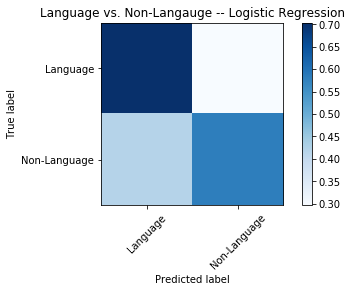

In [44]:
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

target_names = [ 'Language', 'Non-Language']


cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Language vs. Non-Langauge -- Logistic Regression')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Experiment 2 - Language vs. Non-Language, SVM

__Data__: EpochedEEG/20131216_1441_epo.fif (Epoched data from Emmanuil's batch script)

__Problem__: Classify language vs. Non-language epochs 

__Procedure__:
1. filter the epoched data for epochs 1-24 
2. label events by either language or non-language, using the dictionary that Emmanuil created (preprocessing/StimCodes
3. Run SVM classifier on the labeled data. 


In [49]:
lex_data = filtered_epoch_lex._data

In [51]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

cv2 = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
svc = SVC(C=1, kernel='linear')


clf2 = make_pipeline(
                    Vectorizer(),
                    MinMaxScaler(),
                    svc)

preds2 = np.empty(len(filtered_epoch_lex._data))

for train2, test2 in cv2.split(data, labels):
    clf2.fit(data[train2], labels[train2])
    preds2[test2] = clf.predict(data[test2])
    
target_names2 = [ 'L', 'N']
report2 = classification_report(labels, preds2, target_names=target_names2)
print(report2)

             precision    recall  f1-score   support

          L       0.73      0.78      0.75       340
          N       0.73      0.67      0.70       300

avg / total       0.73      0.73      0.73       640



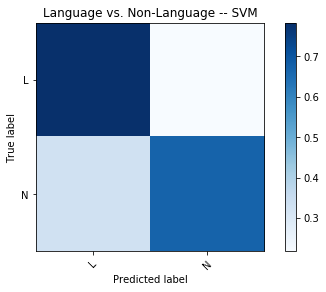

In [52]:
cm2 = confusion_matrix(labels, preds2)
cm2_normalized = cm2.astype(float) / cm2.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm2_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Language vs. Non-Language -- SVM')
plt.colorbar()
tick_marks = np.arange(len(target_names2))
plt.xticks(tick_marks, target_names2, rotation=45)
plt.yticks(tick_marks, target_names2)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 10/24/18 Experiment: Lexicality classification with two files